In [6]:
import numpy as np
import pandas as pd
from pydataset import data

import seaborn as sns

import wrangle

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector

In [2]:
df = data('tips')
df.head()

,total_bill,tip,sex,smoker,day,time,size
1,16.99,1.01,Female,No,Sun,Dinner,2
2,10.34,1.66,Male,No,Sun,Dinner,3
3,21.01,3.50,Male,No,Sun,Dinner,3
4,23.68,3.31,Male,No,Sun,Dinner,2
5,24.59,3.61,Female,No,Sun,Dinner,4


In [3]:
df['price_per_person'] = df.total_bill/df['size']
df.head()

,total_bill,tip,sex,smoker,day,time,size,price_per_person
1,16.99,1.01,Female,No,Sun,Dinner,2,8.495000
2,10.34,1.66,Male,No,Sun,Dinner,3,3.446667
3,21.01,3.50,Male,No,Sun,Dinner,3,7.003333
4,23.68,3.31,Male,No,Sun,Dinner,2,11.840000
5,24.59,3.61,Female,No,Sun,Dinner,4,6.147500


## I believe that party size and total bill will be the most important features to predict the tip amount

In [4]:
cat_col = ['sex', 'smoker', 'day','time']
num_col = ['total_bill', 'sixe']

/opt/homebrew/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 5.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 6.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


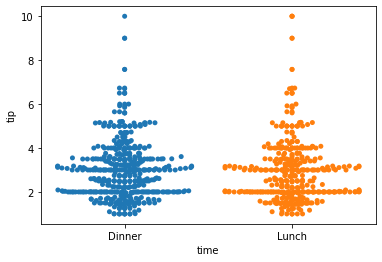

In [7]:
for col in cat_col:
    sns.swarmplot(data = df, x= col, y=df.tip)

In [56]:
df['sex'] = np.where(df.sex == 'Male', 1 , 0)

In [57]:
df['smoker'] = np.where(df.smoker == 'Yes', 1, 0)

In [58]:
def convert_days(df):
    new_day = []
    for n in df:
        if n == 'Thur':
            n = 1
            new_day.append(n)
        elif n == 'Fri':
            n = 2
            new_day.append(n)
        elif n == 'Sat':
            n = 3
            new_day.append(n)
        else:
            n = 4
            new_day.append(n)
    return new_day

In [59]:
df['day'] = convert_days(df.day)

In [60]:
df['time'] = np.where(df.time == 'Lunch', 1, 0)

In [61]:
df.head()

,total_bill,tip,sex,smoker,day,time,size,price_per_person
1,16.99,1.01,0,0,4,0,2,8.495000
2,10.34,1.66,1,0,4,0,3,3.446667
3,21.01,3.50,1,0,4,0,3,7.003333
4,23.68,3.31,1,0,4,0,2,11.840000
5,24.59,3.61,0,0,4,0,4,6.147500


In [62]:
train, validate, test = wrangle.my_train_test_split(df)

In [63]:
train.shape, validate.shape, test.shape

((136, 8), (59, 8), (49, 8))

In [64]:
X_train, y_train = train.drop(columns=['tip']), train.tip
X_validate, y_validate = validate.drop(columns=['tip']), validate.tip
X_test, y_test = test.drop(columns=['tip']), test.tip

In [65]:
X_train.head()

,total_bill,sex,smoker,day,time,size,price_per_person
19,16.97,0,0,4,0,3,5.656667
173,7.25,1,1,4,0,2,3.625000
119,12.43,0,0,1,1,2,6.215000
29,21.70,1,0,3,0,2,10.850000
238,32.83,1,1,3,0,2,16.415000


In [43]:
kbest = SelectKBest(f_regression, k=2)

kbest.fit(X_train, y_train)

# statistical f-value:
kbest.scores_;
# p value:
kbest.pvalues_

array([7.18647033e-20, 2.84479443e-01, 5.57997755e-01, 1.04585545e-01,
       1.82144884e-01, 1.34164190e-12, 1.31032690e-03])

In [44]:
kbest_results = pd.DataFrame(dict(p=kbest.pvalues_, f=kbest.scores_), index = X_train.columns)
kbest_results

,p,f
total_bill,7.186470e-20,115.984909
sex,2.844794e-01,1.154792
smoker,5.579978e-01,0.344909
day,1.045855e-01,2.670276
time,1.821449e-01,1.798647
size,1.341642e-12,61.259089
price_per_person,1.310327e-03,10.777792


In [45]:
X_train.columns[kbest.get_support()]

Index(['total_bill', 'size'], dtype='object')

In [46]:
model = LinearRegression()

In [50]:
rfe = RFE(model, n_features_to_select=3)

rfe.fit(X_train, y_train)

pd.DataFrame(
{
    'rfe_ranking':rfe.ranking_
}, index = X_train.columns)

,rfe_ranking
total_bill,1
sex,1
smoker,5
day,4
time,3
size,2
price_per_person,1


## For Select K the two best features were Total Bill and Party Size, but for Recursive Feature Elimination the two best features were Total_Bill and Sex.  I think this difference in top features is happening because RFE is comparing features to a model where as Select K is only comparing f scores and p value.

In [51]:
def select_kbest(X, y, K):
    
    kbest = SelectKBest(f_regression, k=K)

    kbest.fit(X, y)
    
    return X.columns[kbest.get_support()]

In [68]:
select_kbest(X_train, y_train, 2)

Index(['total_bill', 'size'], dtype='object')

In [69]:
def rfe(X, y, K):
    
    model = LinearRegression()
    
    rfe = RFE(model, n_features_to_select=K)

    rfe.fit(X, y)

    return pd.DataFrame({'rfe_ranking':rfe.ranking_}, index = X_train.columns)

In [70]:
rfe(X_train, y_train, 2)

,rfe_ranking
total_bill,1
sex,1
smoker,6
day,5
time,4
size,3
price_per_person,2


In [71]:
df = data('swiss')
df.head()

,Fertility,Agriculture,Examination,Education,Catholic,Infant.Mortality
Courtelary,80.2,17.0,15,12,9.96,22.2
Delemont,83.1,45.1,6,9,84.84,22.2
Franches-Mnt,92.5,39.7,5,5,93.40,20.2
Moutier,85.8,36.5,12,7,33.77,20.3
Neuveville,76.9,43.5,17,15,5.16,20.6


In [72]:
train, validate, test = wrangle.my_train_test_split(df)

In [73]:
X_train, y_train = train.drop(columns=['Fertility']), train.Fertility
X_validate, y_validate = validate.drop(columns=['Fertility']), validate.Fertility
X_test, y_test = test.drop(columns=['Fertility']), test.Fertility

In [74]:
select_kbest(X_train, y_train, 3)

Index(['Examination', 'Catholic', 'Infant.Mortality'], dtype='object')

In [75]:
rfe(X_train, y_train, 3)

,rfe_ranking
Agriculture,1
Examination,1
Education,2
Catholic,3
Infant.Mortality,1
